In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 15.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 36.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 22.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 709 kB 17.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     

In [ ]:
import random
from collections import Counter
import numpy as np

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from src.dataset import KreuzerSkarkeDataset

## Balance dataset

In [ ]:
dataset_a = KreuzerSkarkeDataset()
len(dataset_a)

78467

In [ ]:
ys = [int(item[1]) for item in dataset_a]

for y, num in zip(Counter(ys).keys(), Counter(ys).values()):
  print(y, ": ", num)

6 :  1
7 :  13
8 :  113
9 :  409
10 :  1148
11 :  2395
12 :  4164
13 :  5976
14 :  7635
15 :  8578
16 :  8848
17 :  8170
18 :  7489
19 :  6049
20 :  4900
21 :  3830
22 :  2699
24 :  1387
25 :  942
23 :  1972
26 :  593
27 :  411
28 :  294
32 :  37
29 :  192
30 :  109
31 :  58
33 :  23
34 :  15
38 :  2
39 :  1
42 :  1
35 :  7
37 :  1
36 :  5


In [ ]:
def permuteMatrix(matrix):
    '''
    :param: matrix: A two-dimensional numpy array, e.g. np.array([[1,2,3],[4,5,6]])
    :return: Rows and columns of this matrix randomly permuted, eg. np.array([[5,4,6],[2,1,3]])
    '''
    numberOfRows = len(matrix)
    numberofColumns = len(matrix[0])
    rowPermutation = list(np.random.permutation(numberOfRows))
    columnPermutation = list(np.random.permutation(numberofColumns))
    newMatrix = matrix[:,columnPermutation]
    newMatrix = newMatrix[rowPermutation]
    return newMatrix

def new_sample(samples, numSamples):
  while len(samples) < numSamples:
    samples.append(permuteMatrix(random.choice(samples)))
  return samples

def balance_classes(data, numSamples=100, moreThan=0):

  balanced = {}
  ys = [int(item[1]) for item in data]
  ys = dict(zip(Counter(ys).keys(), Counter(ys).values()))
  for x, y in data:
    y = int(y)
    if ys[y] < moreThan:
      continue
    if y not in balanced:
      balanced[y] = [x]
    if len(balanced[y]) < numSamples:
      balanced[y].append(x)
  for y, xs in balanced.items():
    numOfYSamples = len(list(xs))
    if numOfYSamples < numSamples:
      balanced[y] = new_sample(list(xs), numSamples)
  #print(balanced.keys())
  #print(balanced[6])

  return [(x, y) for y in balanced.keys() for x in balanced[y]]

balanced_data = balance_classes(dataset_a, numSamples=9000, moreThan=6000)

In [ ]:
ys = [int(item[1]) for item in balanced_data]

for y, num in zip(Counter(ys).keys(), Counter(ys).values()):
  print(y, ": ", num)

14 :  9000
15 :  9000
16 :  9000
17 :  9000
18 :  9000
19 :  9000


## Row-column GNN

In [ ]:
def consrt_occ(numRow, numCol):
    connections = []
    for currRow in range(numRow):
        for currCol in range(numCol):
            currElIdx = currRow*numCol + currCol
            for rowEl in range(numCol):
                if currElIdx != currRow*numCol + rowEl:
                    connections.append([currElIdx, currRow*numCol + rowEl])
            for colEl in range(numRow):
                if currElIdx != colEl*numCol + currCol:
                    connections.append([currElIdx, colEl*numCol + currCol])
    edge_index = torch.tensor(connections).t().contiguous()            
    return edge_index

def init_nodes(matrix):
    matrix = matrix.flatten().reshape(-1, 1)
    return torch.tensor(matrix)

def build_dataset(origDataset):
    graphs = []
    edge_index = consrt_occ(origDataset[0][0].shape[0], origDataset[0][0].shape[1])
    #mapping = np.unique(np.array(origDataset)[:,1])
    #print(mapping, len(mapping))
    for matrix, y in origDataset:
        data = Data()
        data.edge_index = edge_index
        #print(np.where(mapping == y)[0][0])
        data.y = y
        data.x = init_nodes(matrix)
        graphs.append(data)
    return graphs

In [ ]:
a = np.array([[1,2],[1,4],[5,6]])
#b = np.unique(a[:,0])
#np.where(b == 5)[0][0]
build_dataset([[a, 0]])

[Data(edge_index=[2, 18], y=0, x=[6, 1])]

In [ ]:
graphs = build_dataset(balanced_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
random.shuffle(graphs)
trainData = graphs[:int(0.5*len(graphs))]
testData  = graphs[int(0.5*len(graphs)):]

trainLoader = DataLoader(trainData, batch_size=64)
testLoader  = DataLoader(testData,  batch_size=64)

In [ ]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=150):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 43)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
print(model)
#data = trainLoader.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in trainLoader:  # Iterate in batches over the training dataset.
        #print(data.size())
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        #print("prediction: ", pred)
        #print("correct: ", data.y)
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 200):
    train()
    train_acc = test(trainLoader)
    test_acc  = test(testLoader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(1, 150)
  (conv2): GCNConv(150, 150)
  (conv3): GCNConv(150, 150)
  (lin): Linear(in_features=150, out_features=43, bias=True)
)
Epoch: 001, Train Acc: 0.2685, Test Acc: 0.2691
Epoch: 002, Train Acc: 0.2721, Test Acc: 0.2731
Epoch: 003, Train Acc: 0.2717, Test Acc: 0.2740
Epoch: 004, Train Acc: 0.2710, Test Acc: 0.2720
Epoch: 005, Train Acc: 0.2726, Test Acc: 0.2727
Epoch: 006, Train Acc: 0.2708, Test Acc: 0.2716
Epoch: 007, Train Acc: 0.2721, Test Acc: 0.2728
Epoch: 008, Train Acc: 0.2725, Test Acc: 0.2736
Epoch: 009, Train Acc: 0.2719, Test Acc: 0.2732
Epoch: 010, Train Acc: 0.2721, Test Acc: 0.2735
Epoch: 011, Train Acc: 0.2726, Test Acc: 0.2725
Epoch: 012, Train Acc: 0.2726, Test Acc: 0.2737
Epoch: 013, Train Acc: 0.2738, Test Acc: 0.2754
Epoch: 014, Train Acc: 0.2720, Test Acc: 0.2733
Epoch: 015, Train Acc: 0.2735, Test Acc: 0.2743
Epoch: 016, Train Acc: 0.2743, Test Acc: 0.2751
Epoch: 017, Train Acc: 0.2724, Test Acc: 0.2746
Epoch: 018, Train Acc: 0.2732, 

KeyboardInterrupt: ignored

In [ ]:
model.eval()

yTrue = []
yPred = []
for data in testLoader:  # Iterate in batches over the training/test dataset.
    data.to(device)
    out = model(data.x, data.edge_index, data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    yPred.append(pred.tolist())
    yTrue.append(data.y.tolist())
yPred = [item for sublist in yPred for item in sublist]
yTrue = [item for sublist in yTrue for item in sublist]
print(yPred[:5])
print(yTrue[:5])

[17, 17, 19, 19, 14]
[16, 16, 19, 19, 16]


In [ ]:
for y, num in zip(Counter(yTrue).keys(), Counter(yTrue).values()):
  print(y, ": ", num)

16 :  4543
19 :  4510
14 :  4463
15 :  4546
17 :  4469
18 :  4469


In [ ]:
len(Counter(yTrue).keys())

6

In [ ]:
for y, num in zip(Counter(yPred).keys(), Counter(yPred).values()):
  print(y, ": ", num)

17 :  5362
19 :  9267
14 :  8398
15 :  3973


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfm = confusion_matrix(y_true=yTrue, y_pred=yPred)

In [ ]:
import matplotlib.pyplot as plt

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

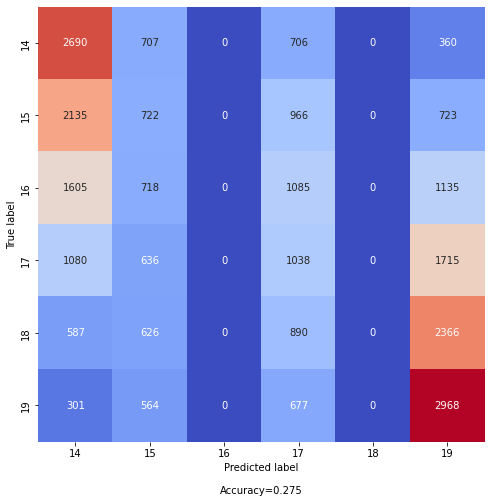

In [ ]:
# Big classes, permutation balancing
make_confusion_matrix(cfm, figsize=(8,8), cbar=False, percent=False, 
                      categories=[str(x) for x in sorted(list(Counter(yTrue).keys()))],
                      cmap="coolwarm")

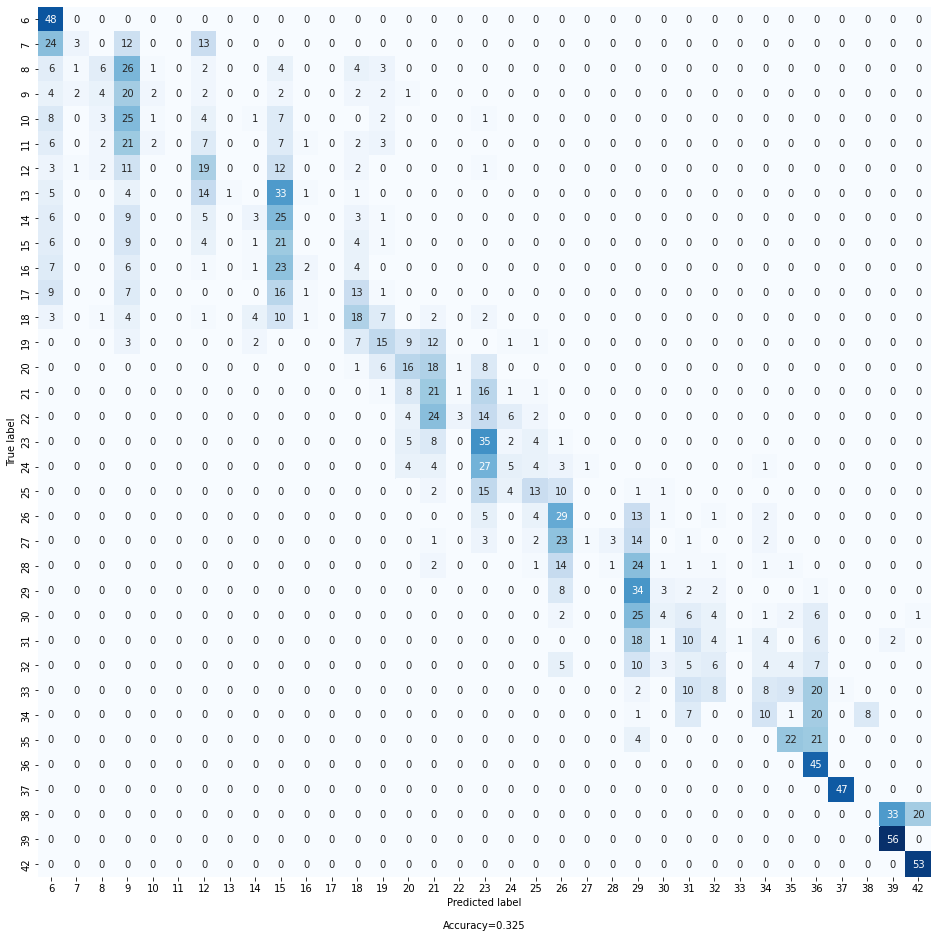

In [ ]:
# All classes, permutation balancing
make_confusion_matrix(cfm, figsize=(16,16), cbar=False, percent=False, 
                      categories=[str(x) for x in sorted(list(Counter(yTrue).keys()))],
                      cmap="coolwarm")

## Point cloud GNN

In [ ]:
balanced_data = balance_classes(dataset_a, numSamples=9000, moreThan=6000)

In [ ]:
def build_points(origDataset):
    graphs = []
    for matrix, y in origDataset:
        data = Data()
        data.y = y
        data.pos = torch.transpose(matrix, 0, 1)
        graphs.append(data)
    return graphs

points = build_points(balanced_data)

In [ ]:
from torch_cluster import knn_graph

for data in points:
  data.edge_index = knn_graph(data.pos, k=10)

In [ ]:
random.shuffle(points)
trainData = points[:int(0.5*len(points))]
testData  = points[int(0.5*len(points)):]

trainLoader = DataLoader(trainData, batch_size=64)
testLoader  = DataLoader(testData,  batch_size=64)

In [ ]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 4, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(4, 50)
        self.conv2 = PointNetLayer(50, 100)
        self.conv3 = PointNetLayer(100, 100)
        self.classifier = Linear(100, 43)
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=6, batch=batch, loop=True)
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv3(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (conv3): PointNetLayer()
  (classifier): Linear(in_features=100, out_features=43, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(trainLoader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 51):
    loss = train(model, optimizer, trainLoader)
    test_acc = test(model, testLoader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 01, Loss: 1.0055, Test Accuracy: 0.5565
Epoch: 02, Loss: 1.0171, Test Accuracy: 0.5413
Epoch: 03, Loss: 0.9970, Test Accuracy: 0.5521
Epoch: 04, Loss: 0.9983, Test Accuracy: 0.5569
Epoch: 05, Loss: 0.9985, Test Accuracy: 0.5601
Epoch: 06, Loss: 0.9841, Test Accuracy: 0.5660
Epoch: 07, Loss: 0.9908, Test Accuracy: 0.5642
Epoch: 08, Loss: 1.0015, Test Accuracy: 0.5625
Epoch: 09, Loss: 0.9879, Test Accuracy: 0.5763
Epoch: 10, Loss: 0.9841, Test Accuracy: 0.5658
Epoch: 11, Loss: 0.9780, Test Accuracy: 0.5760
Epoch: 12, Loss: 0.9684, Test Accuracy: 0.5663
Epoch: 13, Loss: 0.9805, Test Accuracy: 0.5741
Epoch: 14, Loss: 0.9691, Test Accuracy: 0.5776
Epoch: 15, Loss: 0.9770, Test Accuracy: 0.5773
Epoch: 16, Loss: 0.9726, Test Accuracy: 0.5701
Epoch: 17, Loss: 0.9692, Test Accuracy: 0.5704
Epoch: 18, Loss: 0.9625, Test Accuracy: 0.5600
Epoch: 19, Loss: 0.9759, Test Accuracy: 0.5595
Epoch: 20, Loss: 0.9791, Test Accuracy: 0.5628
Epoch: 21, Loss: 0.9854, Test Accuracy: 0.5727
Epoch: 22, Lo

[14, 17, 18, 14, 18]
[14, 17, 19, 14, 17]


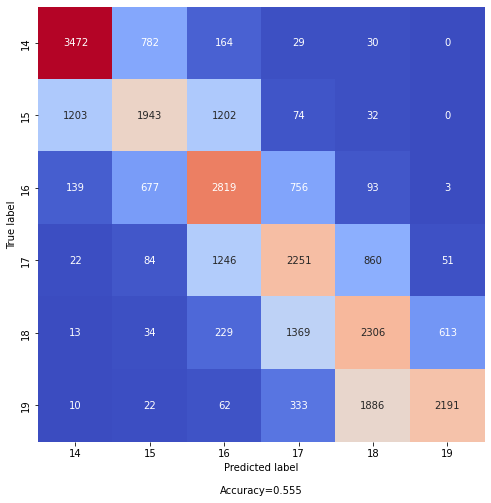

In [ ]:
# k=10, hidden layer=50,100,100, ep=50
model.eval()

yTrue = []
yPred = []
for data in testLoader:  # Iterate in batches over the training/test dataset.
    out = model(data.pos, data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    yPred.append(pred.tolist())
    yTrue.append(data.y.tolist())
yPred = [item for sublist in yPred for item in sublist]
yTrue = [item for sublist in yTrue for item in sublist]
print(yPred[:5])
print(yTrue[:5])

cfm = confusion_matrix(y_true=yTrue, y_pred=yPred)
make_confusion_matrix(cfm, figsize=(8,8), cbar=False, percent=False, 
                      categories=[str(x) for x in sorted(list(Counter(yTrue).keys()))],
                      cmap="coolwarm")

[16, 15, 16, 18, 15]
[18, 15, 16, 19, 14]


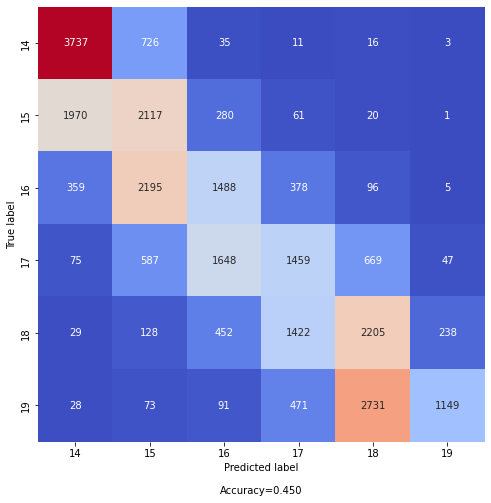

In [ ]:
# k=26, hidden layer=50,100, ep=10
model.eval()

yTrue = []
yPred = []
for data in testLoader:  # Iterate in batches over the training/test dataset.
    out = model(data.pos, data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    yPred.append(pred.tolist())
    yTrue.append(data.y.tolist())
yPred = [item for sublist in yPred for item in sublist]
yTrue = [item for sublist in yTrue for item in sublist]
print(yPred[:5])
print(yTrue[:5])

cfm = confusion_matrix(y_true=yTrue, y_pred=yPred)
make_confusion_matrix(cfm, figsize=(8,8), cbar=False, percent=False, 
                      categories=[str(x) for x in sorted(list(Counter(yTrue).keys()))],
                      cmap="coolwarm")

[19, 19, 19, 14, 19]
[19, 18, 19, 14, 19]


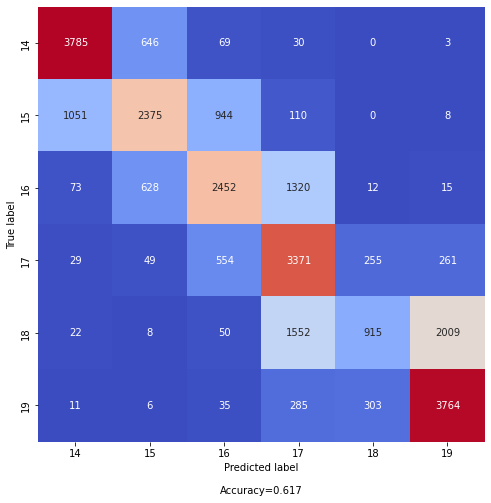

In [ ]:
# k=5, hidden layer=50,100, ep=100
model.eval()

yTrue = []
yPred = []
for data in testLoader:  # Iterate in batches over the training/test dataset.
    out = model(data.pos, data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    yPred.append(pred.tolist())
    yTrue.append(data.y.tolist())
yPred = [item for sublist in yPred for item in sublist]
yTrue = [item for sublist in yTrue for item in sublist]
print(yPred[:5])
print(yTrue[:5])

cfm = confusion_matrix(y_true=yTrue, y_pred=yPred)
make_confusion_matrix(cfm, figsize=(8,8), cbar=False, percent=False, 
                      categories=[str(x) for x in sorted(list(Counter(yTrue).keys()))],
                      cmap="coolwarm")

[14, 14, 16, 19, 17]
[14, 14, 15, 18, 17]


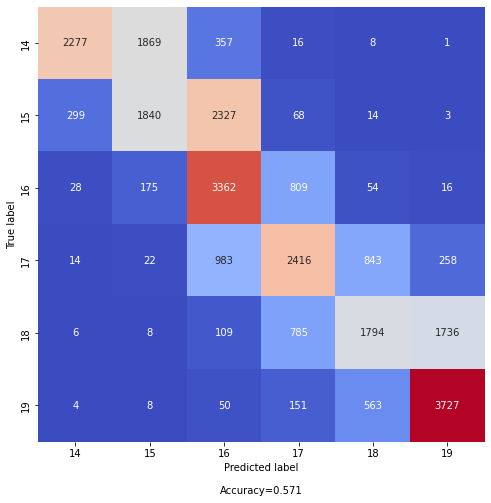

In [ ]:
# k=6, hidden layer=32, ep=100
model.eval()

yTrue = []
yPred = []
for data in testLoader:  # Iterate in batches over the training/test dataset.
    out = model(data.pos, data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    yPred.append(pred.tolist())
    yTrue.append(data.y.tolist())
yPred = [item for sublist in yPred for item in sublist]
yTrue = [item for sublist in yTrue for item in sublist]
print(yPred[:5])
print(yTrue[:5])

cfm = confusion_matrix(y_true=yTrue, y_pred=yPred)
make_confusion_matrix(cfm, figsize=(8,8), cbar=False, percent=False, 
                      categories=[str(x) for x in sorted(list(Counter(yTrue).keys()))],
                      cmap="coolwarm")